# Virtual linac guide

- [Introduction](#Introduction)
- [Helper functions](#Helper-functions)
- [AWS (Amazon web service)](#AWS)
- [VirtuaLinac API](#VirtuaLinac-API)
- [Plot .dose data](#Plot-.dose-data)
- [Calculation with my phantom](#Calculation-with-my-phantom)
- [Terminate](#Terminate)

# Introduction

ALWAYS NEED TO EDIT INSTANCE SECURITY GROUP > INCOMING > HTTP > FROM MY IP

Follow guide on http://radiotherapyresearchtools.com/doc/api_tutorial.html

For parsing HTML https://www.crummy.com/software/BeautifulSoup/

In [1]:
%load_ext watermark
%watermark -a 'Robin Cole' -u -d -v -p numpy,pandas,matplotlib

Robin Cole 
last updated: 2016-09-22 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1


In [28]:
import boto3
import requests
import re
from bs4 import BeautifulSoup
import vl_api_helper as vl   # Daren helper files
from time import localtime, strftime  # to print time
import plotdose as vlplt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pprint
import os
import pickle
%matplotlib inline

# Helper functions

In [29]:
def get_jobs():
    r = requests.get(url + '/usage') 
    for line in r.text.split('\n'):
        if 'Number of jobs' in line:
            print(url + '/usage') 
            print(line)
            print(strftime("%H:%M:%S", localtime()))

In [30]:
def print_files(url):    # Helper function to print list of files on server
    resp = requests.get(url + '/phspfiles') # get page with list of output files
    soup = BeautifulSoup(resp.text, 'html.parser')   
    my_list = []
    for link in soup.find_all('a'):   # get all links
        my_list.append(link.get('href'))
    results = [k for k in my_list if '/vl_files/' in k]  # get only links from vl_files
    for item in results:
        pprint.pprint(re.sub('/vl_files/', '', item))  # use pprint and strip vl_files

In [31]:
def download_file(url, file):    # my own helper function to download files
    r = requests.get(url + '/vl_files/' + file, stream=True)
    f = open(file, 'wb')     # use 'wb' write binary
    f.write(r.content)
    f.close()
    print(file, " downloaded at ", strftime("%H:%M:%S", localtime()), " File size (Bytes)", os.path.getsize(file))

In [32]:
def save_params(params):    # write params dict to a pickle
    filename = params['filename']   
    filename += ".p"
    print(filename)
    pickle.dump(params, open(filename, "wb"))

In [33]:
# Useage print_params('params1.p')
def print_params(params_file):      # pass filename of params pickle object, ege 'params1.p'
    pprint.pprint(pickle.load(open(params_file, "rb")))

# AWS

Logon to AWS, start virtualinac instance, edit security group to accept incoming HTTP

In [34]:
ec2=boto3.resource('ec2')
instances = ec2.instances.filter(Filters=
    [{'Name': 'instance-state-name', 'Values': ['running'] }])

In [56]:
dns_names = []
for instance in instances:
        #print(instance.public_dns_name)
        dns_names.append(instance.public_dns_name)
url = 'http://' + dns_names[0]
print(url)

http://ec2-54-85-201-212.compute-1.amazonaws.com


View the URL to browe files etc

In [36]:
print_files(url) # Check files at start of instance - I deleted them all

'gantry.xml'


# VirtuaLinac API

In [37]:
# all sizes in mm
rc_test2 = {
    'filename'     : 'rc_test2',
    'code_version' : 0,
    'physics_list' : 0,
    'beam_type'    : 0,
    'range_cut' : 10,
    'energy'       : 6.84,
    'energy_spread' : 0.6,
    'spot_size_x'  : 0.7,
    'spot_size_y'  : 0.7,
    'beam_divergence_x' : 0.0,
    'beam_divergence_y' : 0.0,
    'jaw_position_y1' : -20,   # cm
    'jaw_position_y2' :  20,
    'jaw_position_x1' : -20,
    'jaw_position_x2' :  20,
    'phantom_bool' : 'True',     # Create the phantom? if None then uses phantom file
    'phantom_size_x' : 500,
    'phantom_size_y' : 500,
    'phantom_size_z' : 400,
    'phantom_voxels_x' : 125,
    'phantom_voxels_y' : 125,
    'phantom_voxels_z' : 100,
    'phantom_position_x' : 0,
    'phantom_position_y' : 0,
    'phantom_position_z' : -20,    # distances in cm relative to isocentre.  
    'incident_particles' : 100000,    # increased from 10000
    'brem_splitting' : None,   # increased from none
    'splitting_factor' : None,
    'phsp_record'  : None
}

In [38]:
r = requests.post(url, params=rc_test2)   # Submit calculation
save_params(rc_test2)
#print_params('rc_test2.p')

rc_test2.p


In [66]:
get_jobs()

http://ec2-54-85-201-212.compute-1.amazonaws.com/usage
<p><b>Number of jobs:</b> 0 </p>
09:32:48


In [57]:
print_files(url) # On calculation completion, get files 

'rc_666.dose'
'rc_666.mac'
'rc_666.output'
'rc_777.dose'
'rc_777.mac'
'rc_777.output'


In [61]:
download_file(url, 'rc_666.dose') # download .dose file

rc_666.dose  downloaded at  09:25:30  File size (Bytes) 2282329


# Plot .dose data

This calculation was submitted by the web page, not the API. Took approx. 19 hours to run on a single core.

Output file name: rc_777
/gun/particle e-

/source/type random

/source/energy 6.5 MeV

/source/energySigma 0.6 MeV

/source/spotSizeX 0.6 mm

/source/spotSizeY 0.6 mm

/source/spotPositionX 0 mm

/source/spotPositionY 0 mm

/source/beamAngleX 0 deg

/source/beamAngleY 0 deg

/source/beamDivergenceX 0 deg

/source/beamDivergenceY 0 deg

/run/setCut 100 um

/process/em/setSecBiasing eBrem target 100 100 MeV

/detector/flatteningFilterName 6X
/detector/jawPositionX1 -20.0 cm

/detector/jawPositionX2 20.0 cm

/detector/jawPositionY1 -20.0 cm

/detector/jawPositionY2 20.0 cm

/detector/collimatorRotation 0.0 deg

/detector/applicator None

/parallel/phantomNumber 50 50 400

Setting phantom voxels to :(50,50,400)

Build water phantom.

Particles 1000000

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 20
Number of voxels in phantom.  nx: 50 ny: 50 nz: 400
i_max: 32


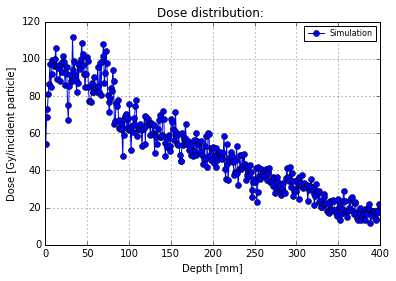

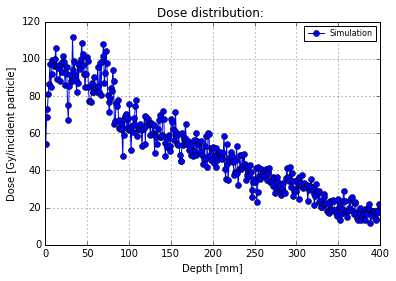

In [67]:
vlplt.plotdose('rc_777.dose', xplot=25, yplot=25, zplot=20, plotdir='z')   # xplot = Number of bins?

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 20
Number of voxels in phantom.  nx: 50 ny: 50 nz: 400


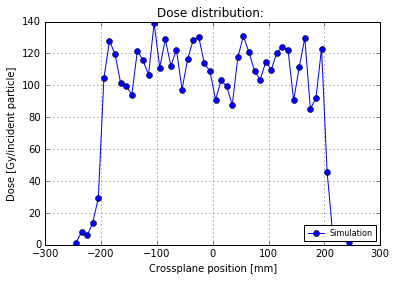

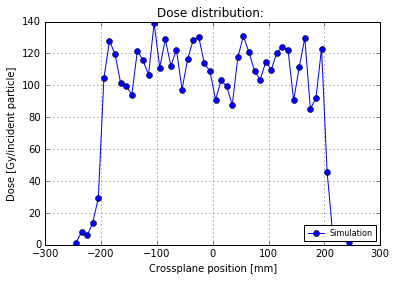

In [63]:
vlplt.plotdose('rc_777.dose', xplot=25, yplot=25, zplot=20, plotdir='x')   # xplot = Number of bins?

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 6
Number of voxels in phantom.  nx: 50 ny: 50 nz: 400


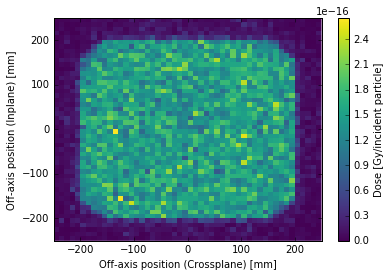

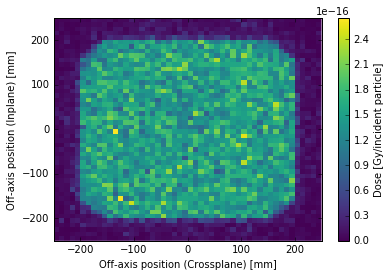

In [64]:
vlplt.plotdose('rc_777.dose', xplot=25, yplot=25, zplot=6, plotdir='z', dimension=2) 

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 6
Number of voxels in phantom.  nx: 50 ny: 50 nz: 400


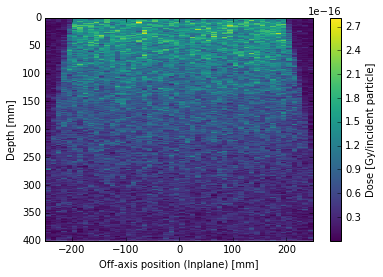

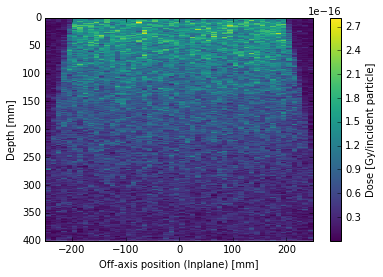

In [65]:
vlplt.plotdose('rc_777.dose', xplot=25, yplot=25, zplot=6, plotdir='x', dimension=2) 

For online plotting

In [14]:
filename = 'rcl'
doseparams = {}
doseparams['direction'] = 'z'
doseparams['average'] = 5
doseparams['colormap'] = 'True'
extension = '2d.z.png'
plot_url = url + '/fig/' + filename + '.dose'
extension = '.z_compare.png'
r = requests.get(plot_url, params=doseparams, stream=True)
with open(filename + extension, 'wb') as f:
    for chunk in r.iter_content():
        f.write(chunk)

In [25]:
# mpimg.imread('rcl.z_compare.png')

<hr>

# Calculation with my phantom

I have run create_ct.py on my CT dataset to create tmp.phantom

http://radiotherapyresearchtools.com/doc/output.html#simulate-phantom-and-how-to-build-a-phantom

In [3]:
filename = 'tmp.phantom'
upload_files = {'file': open(filename, 'rb')}
r = requests.post(url + '/upload', files=upload_files)

NameError: name 'url' is not defined

phantom size [mm]: 353.28 50.0 353.28
Voxels to plot. xplot: 250 yplot: 5 zplot: 250
Number of voxels in phantom.  nx: 512 ny: 10 nz: 512
i_max: 477


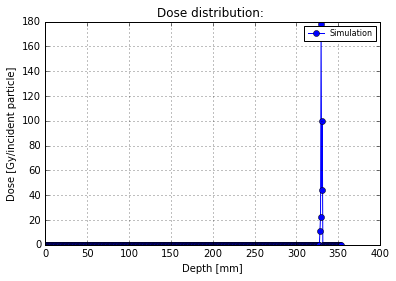

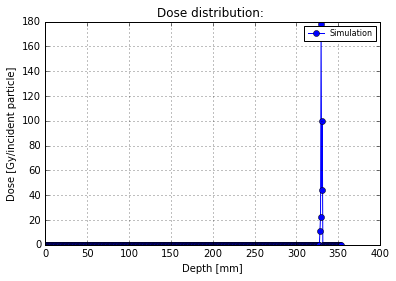

In [4]:
vlplt.plotdose(filename, xplot=250 , yplot=5, zplot=250, plotdir='z')  # Can plot phantom..

phantom size [mm]: 300.0 600.0 300.0
Voxels to plot. xplot: 29 yplot: 59 zplot: 29
Number of voxels in phantom.  nx: 30 ny: 60 nz: 30


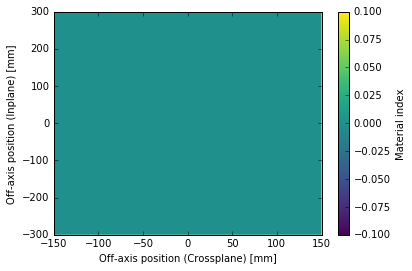

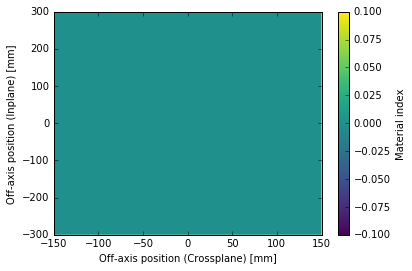

In [44]:
vlplt.plotdose('cylinder.phantom', xplot=29, yplot=59, zplot=29, plotdir='z', dimension=2)   # Can plot phantom..

In [37]:
params2 = {
    'filename'     : 'api_test_1',
    'code_version' : 0,
    'physics_list' : 0,
    'beam_type'    : 0,
    'range_cut' : 10,
    'energy'       : 6.84,
    'energy_spread' : 0.6,
    'spot_size_x'  : 0.7,
    'spot_size_y'  : 0.7,
    'beam_divergence_x' : 0.0,
    'beam_divergence_y' : 0.0,
    'jaw_position_y1' : -20,
    'jaw_position_y2' :  20,
    'jaw_position_x1' : -20,
    'jaw_position_x2' :  20,
    'phantom_bool' : None,
    'phantom_file_name': 'tmp.phantom',
    'phantom_position_x' : 0,
    'phantom_position_y' : 0,
    'phantom_position_z' : -5,
    'incident_particles' : 100000000,
    'brem_splitting' : None,
    'splitting_factor' : None,
    'phsp_record'  : None
}

In [264]:
r = requests.post(url, params=params2)  # get page with list of output files

In [266]:
get_jobs()

<p><b>Number of jobs:</b> 0 </p>
12:40:06


In [267]:
download_file(url, 'testing.dose') # download .dose file

testing.dose  downloaded at  12:40:08  File size (Bytes) 219281


phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 39
Number of voxels in phantom.  nx: 50 ny: 50 nz: 40
i_max: 4


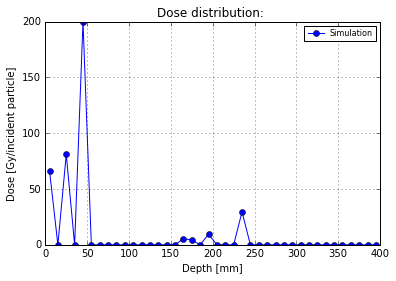

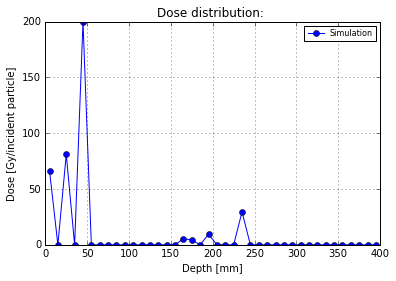

In [268]:
vlplt.plotdose('testing.dose', xplot=25, yplot=25, zplot=40, plotdir='z')   # xplot = Number of bins?

phantom size [mm]: 500.0 500.0 400.0
Voxels to plot. xplot: 25 yplot: 25 zplot: 6
Number of voxels in phantom.  nx: 50 ny: 50 nz: 40


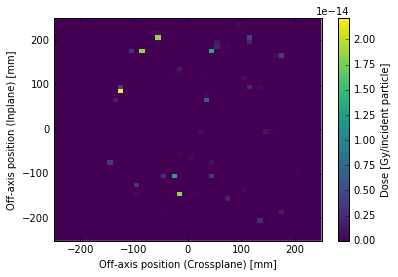

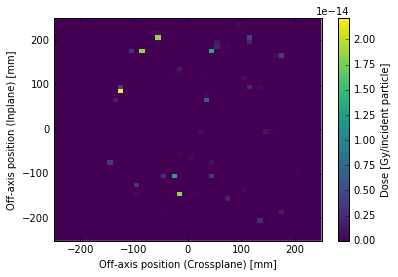

In [269]:
vlplt.plotdose('testing.dose', xplot=25, yplot=25, zplot=6, plotdir='z', dimension=2) 

# Terminate

In [18]:
instances.terminate()  # to terminate

[{'ResponseMetadata': {'HTTPHeaders': {'content-type': 'text/xml;charset=UTF-8',
    'date': 'Wed, 21 Sep 2016 16:07:30 GMT',
    'server': 'AmazonEC2',
    'transfer-encoding': 'chunked',
    'vary': 'Accept-Encoding'},
   'HTTPStatusCode': 200,
   'RequestId': '89d35df7-e6a5-4325-a64b-aebf6efb5477',
   'RetryAttempts': 0},
  'TerminatingInstances': [{'CurrentState': {'Code': 32,
     'Name': 'shutting-down'},
    'InstanceId': 'i-09fb569c68874e766',
    'PreviousState': {'Code': 16, 'Name': 'running'}}]}]